# Randomization Test: Creating cluster permutations
In this notebook, 1000 permutations of cluster definitions are created by randomly assigning stations to 7 clusters in each permutation. The number of datapoints in each cluster is determined by sampling from a 7th order Dirichlet distribution (Eq. 1) in each iteration.

$$ f(y^7) = \frac{\Gamma(\alpha_0)}{\prod_{i=1}^{7} \Gamma(\alpha_i)} \prod_{i=1}^{7} y_i^{\alpha_i - 1} \tag{1}$$

$$  \alpha_0 = \sum^{7}_{i=1} \alpha_i $$

The parameters of the Dirichlet distribution were defined as follows:

$$ \alpha_i =  \frac{\beta n_i}{N} \tag{2}$$

Where:
* $n_i$: The number of data points in the ith region of the regions used in this study
* $N$: The total number of datapoints
* $\beta$: Concentration parameter

By using this parameter definition, the mean of this 7th order Dirichlet distribution (Eq. 3) would be a 7 dimensional vector, where each of its 7 values represents the ratio of the region dataset size to the total number of datapoints. The value of the concentration parameter determines how dispersed are the samples around the mean.

$$  E[y_i] = \frac{\alpha_i}{\alpha_0} \tag{3}$$

Source:
* Daniel Johnson (https://stats.stackexchange.com/users/8242/daniel-johnson), How to sample natural numbers, such that the sum is equal to a constant?, URL (version: 2012-03-01): https://stats.stackexchange.com/q/23959

**Note**:
* The functions used in this notebook are found in *ETProject/RandomizationTest*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.stats import dirichlet

# Changing directory path
main_dir_path = Path.cwd().parents[0]
os.chdir(main_dir_path)

from ETProject.RandomizationTest import *

Loading data

In [2]:
path = 'processed_data/station_definitions.csv'
st_def = pd.read_csv(path)

path = 'processed_data/et_data.csv'
all_data = pd.read_csv(path)

Exploring original regions

In [19]:
all_data.groupby('region')[['st_num']].aggregate(['count', 'nunique'])

st_num        
                       count nunique
region                              
Aegean                  8328      33
Black Sea               4488      20
Central Anatolia       10020      35
Eastern Anatolia        7932      22
Marmara                 6012      28
Mediterranean           5028      19
Southeastern Anatolia   2580       8

In [25]:
original_data_cluster_sizes = all_data.groupby('region')['st_num'].count().to_numpy()
original_data_cluster_sizes

array([ 8328,  4488, 10020,  7932,  6012,  5028,  2580], dtype=int64)

## Creating cluster permutations
A total of 1150 permutations were created, where only 1000 are required for the randomization test. The additional 150 are to replace the permutations with extreme values as descriped below.

In [52]:
# Creating 1150 permutations to replace the permutations with extreme
# cluster ratio and test ratio values and obtain 1000 permutations
n = 1150

# Uncomment the following line to create cluster permutations
# df = permutate_clusters(n, all_data)

In [30]:
df.head()

,st_num,iter,cluster,dataset
0,17246,1,1,test
1,17981,1,1,train
2,17674,1,1,train
3,17608,1,1,test
4,17070,1,1,train


In [55]:
def get_permutation_test_stats(perm_data, all_data):
    '''
    Return a dataframe containing the test_ratio and cluster ratio
    of each cluster in all permutations.
    '''
    vals_per_station = all_data['st_num'].value_counts()
    
    # List to combine iteration stats
    df_list = []
    
    clusters = perm_data['cluster'].unique()
    
    for iter_num in perm_data['iter'].unique():
        cond = perm_data['iter'] == iter_num
        df = perm_data[cond]
        
        test_ratios = []
        cluster_ratios = []
        
        for cluster in clusters:
            cond = df['cluster'] == cluster
            stations = df.loc[cond, 'st_num'].to_list()
            n_data = vals_per_station[stations].sum()
            cluster_ratios.append(n_data / vals_per_station.sum())
            
            # Test ratio
            cond1 = df['dataset'] == 'test'
            test_stations = df.loc[(cond & cond1), 'st_num'].to_list()
            test_ratios.append(vals_per_station[test_stations].sum() / n_data)
            
        df_list.append(pd.DataFrame({
            'iter': iter_num,
            'cluster': clusters,
            'cluster_ratio': cluster_ratios,
            'test_ratio': test_ratios
        }))
        
    return pd.concat(df_list, ignore_index=True)

In [31]:
perm_stats = get_permutation_test_stats(df, all_data)

In [39]:
# Original data cluster ratios
np.sort(original_data_cluster_sizes / all_data.shape[0])[::-1]

array([0.22573669, 0.18761828, 0.17869695, 0.13544201, 0.11327386,
       0.10110841, 0.05812382])

Clustyer permutations with extreem values are dropped as follows:
* Cluster ratios less than 0.03 are dropped
* Out of the remaining 150 additional permutations after dropping the previous condition, the highest test_ratios are dropped.

In [150]:
n_to_drop = 150

# Dropping cluster ratios less than 0.03
cond = perm_stats['cluster_ratio'] < 0.03
iter_to_drop = perm_stats.loc[cond, 'iter'].to_list()
n_to_drop = n_to_drop - np.unique(iter_to_drop).shape[0]

# Dropping highest test ratios
while n_to_drop > 0:
    cond = perm_stats['iter'].isin(iter_to_drop)
    iter_to_drop += perm_stats.loc[~cond].sort_values(by=['test_ratio'], ascending=False).head(n_to_drop)['iter'].to_list()
    n_to_drop = 150 - np.unique(iter_to_drop).shape[0]
    
iter_to_drop = np.unique(np.array(iter_to_drop))

In [164]:
# Constructing new permutation dataframe
cond = df['iter'].isin(iter_to_drop)
df1 = df.drop(index=df[cond].index)

# Renumber iterations (permutation numbers)
repl_dict = dict(zip(np.sort(df1['iter'].unique()), np.arange(1, df1['iter'].unique().shape[0]+1)))
df1['iter'] = df1['iter'].replace(repl_dict)

In [40]:
mod_perm_stats = get_permutation_test_stats(df1, all_data)

In [41]:
mod_perm_stats.groupby('cluster')[['cluster_ratio', 'test_ratio']].aggregate(['min', 'max', 'mean'])

cluster_ratio                     test_ratio                    
                  min       max      mean        min       max      mean
cluster                                                                 
1            0.110570  0.408218  0.222569   0.345840  0.477941  0.388934
2            0.089484  0.307921  0.184600   0.338614  0.482000  0.391998
3            0.080562  0.283861  0.175424   0.317130  0.499246  0.392705
4            0.058124  0.276021  0.136444   0.318091  0.520690  0.402149
5            0.038118  0.210868  0.113714   0.302949  0.532609  0.409463
6            0.031089  0.215734  0.102064   0.315018  0.555556  0.413248
7            0.030008  0.177886  0.065184   0.295597  0.556291  0.430561

In [42]:
mod_perm_stats['test_ratio'].mean()

0.40415111294885386

### Plotting permutation cluster ratios and test dataset ratios
*The diamond markers represent the ratio of the region dataset size to the total dataset size of the corresponding region dataset used this study. Ex: Cluster 1 simulates Central Anatolia, i.e., the largest region dataset.*

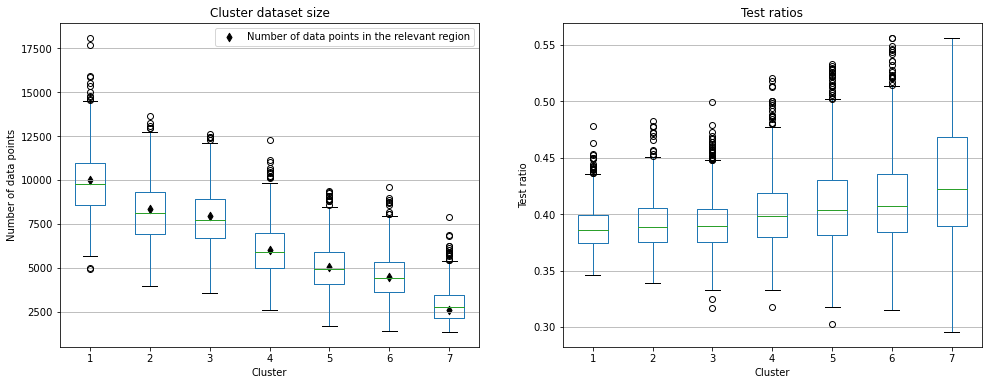

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
dataset_size = all_data.shape[0]

# Plotting cluster dataset sizes
ax = axs[0]
graph = perm_stats.copy()
graph['cluster_size'] = dataset_size * graph['cluster_ratio']
graph.boxplot(ax=ax, column='cluster_size', by='cluster')

ax.grid(axis='x')
x = np.arange(1, len(original_data_cluster_sizes)+1)
ax.scatter(x=x, y=np.sort(original_data_cluster_sizes)[::-1], marker='d', color='black', label='Number of data points in the relevant region')

# Annotation
ax.set_ylabel('Number of data points')
ax.set_xlabel('Cluster')
ax.set_title('Cluster dataset size')

ax.legend()

# Plotting test ratio boxplot
ax = axs[1]
mod_perm_stats.boxplot(ax=ax, column='test_ratio', by='cluster')
ax.grid(axis='x')
ax.set_xlabel('Cluster')
ax.set_ylabel('Test ratio')
ax.set_title('Test ratios')

fig.suptitle(None)
plt.show()

In [174]:
df1 = df1.sort_values(['iter', 'cluster'])

In [175]:
path = 'randomization_test'

file_name = 'cluster_permutations.csv'
# df1.to_csv(os.path.join(path, file_name), index=False)

file_name = 'permutation_stats.csv'
# mod_perm_stats.to_csv(os.path.join(path, file_name), index=False)